In [27]:
from import_data import *
from cleaning import *
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble.partial_dependence import plot_partial_dependence,partial_dependence
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,roc_auc_score,roc_curve
from sklearn.ensemble import GradientBoostingClassifier
from model import *
from sklearn.model_selection import GridSearchCV

In [33]:
now = datetime.datetime.now()
this_year = now.year
this_year
salary = get_data('data/salary.p')
stats = get_data('data/stats.p')
free_agents = get_data('data/free_agents.p')
add_features(stats)
final_data = combine_data(salary,stats,free_agents)
final_data = cleaning(final_data)
# final_data['Type'] = final_data['Type'].apply(lambda x: 'RFA' if x == 'CO' else x).apply(lambda x: 'UFA' if x == 'PO' else x)
dummies_data = pd.get_dummies(final_data,columns=['Type','Pos.'])
fa_this_year = dummies_data[dummies_data['Year']==this_year]
final_data1 = dummies_data[dummies_data['Year']!=this_year]
X = final_data1.drop(['Churn','Tm','Year','Salary'],axis=1)
y = final_data1['Churn']
X1, x_val, y1, y_val = train_test_split(X,y,test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X1,y1)

In [3]:
# gbc = GradientBoostingClassifier()
# gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [17]:
# probs = gbc.predict_proba(X_test)[:, 1]
# preds = get_preds(probs,y_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# f1_score(y_test,preds)

0.8789571694599628

In [28]:
# params = {'learning_rate':[0.001,0.005,0.01,0.05,0.1,0.2],
#           'n_estimators':[25,50,75,100,150,200,250,300,350],
#           'max_depth':[2,5,8,10,12,15],
#           'max_features':[None,'sqrt'],
#           'subsample':[0.25,0.5,0.75,1]}
# gbc = GradientBoostingClassifier()
# gs = GridSearchCV(gbc,param_grid=params,scoring='roc_auc',cv=3).fit(X_train,y_train)
# gs.best_params_

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1,
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 25,
 'subsample': 0.5}

In [80]:
gbc_gs = GradientBoostingClassifier(learning_rate=0.01,max_depth=2,max_features='sqrt',n_estimators=300,subsample=0.75)
gbc_gs.fit(X_train,y_train)
probs_gs = gbc_gs.predict_proba(X_test)[:, 1]
thresh,preds_gs = get_preds(probs_gs,y_test)
f1_score(y_test,preds_gs),sum(preds_gs==y_test)/len(y_test)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.8970588235294118, 0.825)

In [81]:
probs_val_set = gbc_gs.predict_proba(x_val)[:,1]
preds_val_set = (probs_val_set>thresh).astype(int)
f1_score(y_val,preds_val_set),sum(preds_val_set==y_val)/len(preds_val_set)

(0.8803418803418803, 0.8041958041958042)

In [82]:
roc_auc_score(y_test,probs_gs)

0.713468720821662

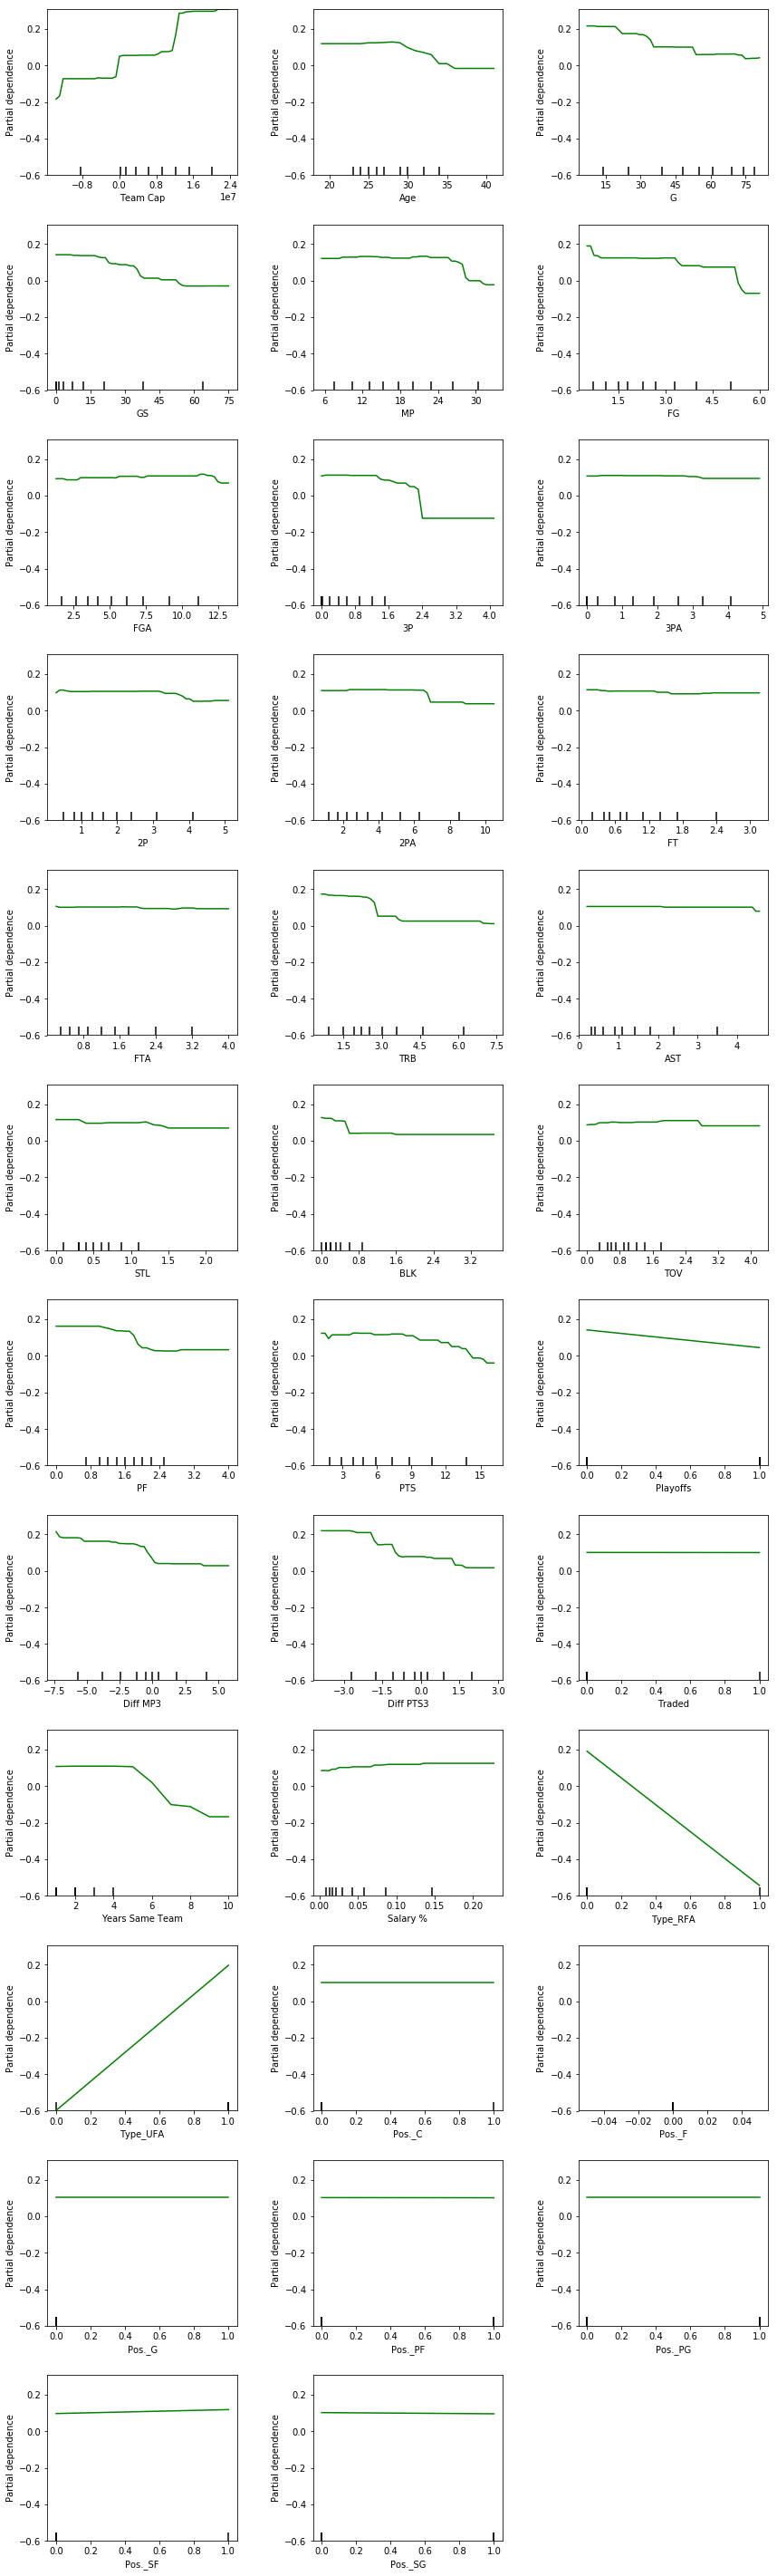

In [83]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, range(35),
                                   feature_names=X_train.columns,
                                    grid_resolution=50,figsize=(13,8))
plt.subplots_adjust(top=5)
#plt.savefig('img/cluster2_important_depend.png')

In [86]:
X_train.columns

Index(['Team Cap', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P',
       '2PA', 'FT', 'FTA', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Playoffs', 'Diff MP3', 'Diff PTS3', 'Traded', 'Years Same Team',
       'Salary %', 'Type_RFA', 'Type_UFA', 'Pos._C', 'Pos._F', 'Pos._G',
       'Pos._PF', 'Pos._PG', 'Pos._SF', 'Pos._SG'],
      dtype='object')

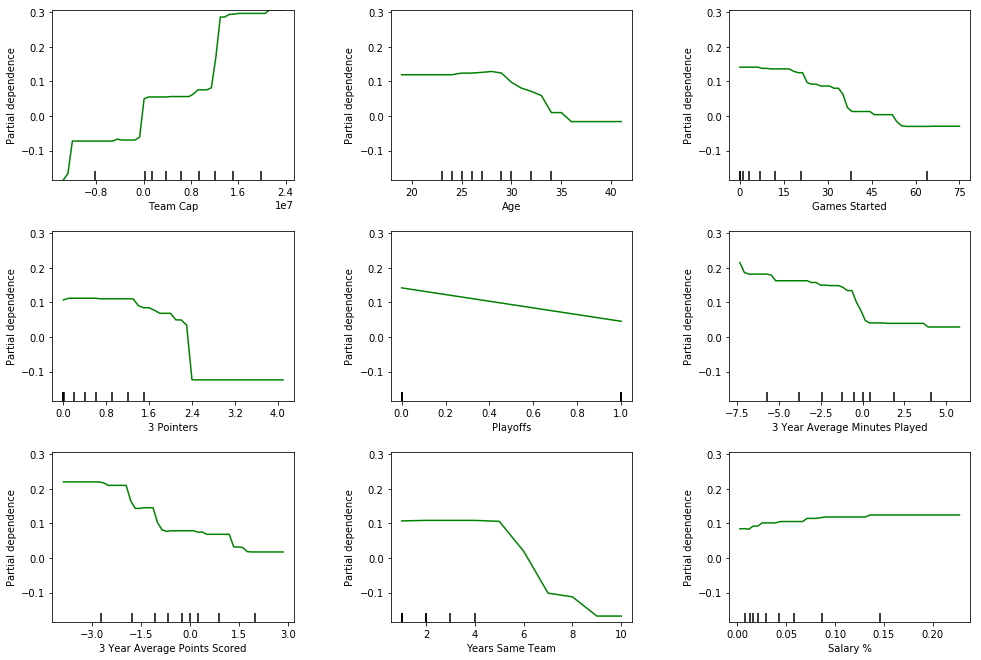

In [89]:
fig , axs = plot_partial_dependence(gbc_gs, X_train.values, [0,1,3,7,20,21,22,24,25],
                                   feature_names=['Team Cap','Age','Games Played','Games Started','Minutes Played','Field Goals','Field Goals Attempted','3 Pointers','3 Pointers Attempted','2 Pointers','2 Pointers Attempted','Free Throws','Free Throws Attempted','Total Rebounds','Assists','Steals','Blocks','Turnovers','Fouls','Points','Playoffs','3 Year Average Minutes Played','3 Year Average Points Scored','Traded','Years Same Team','Salary %','Restricted Free Agent','Unrestricted Free Agent','Center','Forward','Guard','Power Forward','Point Guard','Small Forward','Shooting Guard'],
                                    grid_resolution=50,figsize=(15,10))
plt.subplots_adjust(top=1)
plt.savefig('img/part_depend.png')

In [91]:
fa_this_year['Playoffs'] = 1
X_this = fa_this_year.drop(['Churn','Year','Salary','Tm'],axis=1)
this_year_probs = gbc_gs.predict_proba(X_this)
this_year_preds = (this_year_probs[:,1]>thresh).astype(int)

/Users/MSteele/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
this_year_final = pd.concat([pd.Series(fa_this_year.index),pd.Series(this_year_probs[:,1]),pd.Series(this_year_preds)],axis=1)
this_year_final.rename({0:'Player',1:'Probability',2:'Prediction'},axis=1,inplace=True)
this_year_final.set_index('Player',inplace=True)

In [98]:
players_staying = this_year_final[this_year_final['Prediction']==0]
players_staying.sort_values('Probability',ascending=False)

,Probability,Prediction
Player,,
Alex Poythress,0.528536,0
Sam Dekker,0.526616,0
Johnathan Williams,0.526184,0
Patrick McCaw,0.525350,0
Quinn Cook,0.525080,0
Khem Birch,0.516623,0
Jalen Jones,0.515677,0
Jordan Bell,0.514979,0
Alex Caruso,0.512196,0


In [103]:
thresh

0.530605860684808

In [102]:
players_leaving = this_year_final[this_year_final['Prediction']==1]
players_leaving[:50].sort_values('Probability',ascending=False)

,Probability,Prediction
Player,,
Jerryd Bayless,0.874223,1
Isaiah Thomas,0.869872,1
Luc Mbah a Moute,0.866117,1
Troy Daniels,0.861175,1
Pau Gasol,0.859334,1
Wesley Johnson,0.854664,1
Dante Cunningham,0.854095,1
Anthony Tolliver,0.853347,1
Luol Deng,0.853028,1


In [104]:
players_leaving[50:100].sort_values('Probability',ascending=False)

,Probability,Prediction
Player,,
Thabo Sefolosha,0.856419,1
Ian Clark,0.854663,1
Alan Williams,0.854647,1
Amir Johnson,0.853344,1
Cory Joseph,0.843975,1
Kosta Koufos,0.841917,1
Christian Wood,0.838751,1
Lance Stephenson,0.837755,1
Tim Frazier,0.836842,1


In [105]:
players_leaving[100:150].sort_values('Probability',ascending=False)

,Probability,Prediction
Player,,
Quincy Pondexter,0.876376,1
Michael Carter-Williams,0.855750,1
Salah Mejri,0.846607,1
Tyler Lydon,0.842442,1
Furkan Korkmaz,0.841852,1
Marquese Chriss,0.835089,1
Dragan Bender,0.832686,1
Michael Kidd-Gilchrist,0.829799,1
Trey Burke,0.820137,1


In [106]:
players_leaving[150:].sort_values('Probability',ascending=False)

,Probability,Prediction
Player,,
Davon Reed,0.687782,1
Daryl Macon,0.667923,1
Angel Delgado,0.651947,1
Jared Terrell,0.633614,1
Drew Eubanks,0.626731,1
Brandon Goodwin,0.620152,1
Joe Chealey,0.608933,1
Troy Caupain,0.601523,1
Brandon Sampson,0.594408,1


In [94]:
final_data.groupby('Tm').mean()['Churn'].sort_values()

Tm
MIA    0.617021
SAS    0.617021
HOU    0.677419
DEN    0.689655
CHI    0.690476
GSW    0.714286
DAL    0.730159
NOH    0.733333
NJN    0.750000
MEM    0.750000
LAC    0.750000
LAL    0.754098
UTA    0.772727
CLE    0.775000
ATL    0.775510
NOP    0.777778
BOS    0.788462
NYK    0.789474
OKC    0.793103
TOT    0.799383
TOR    0.800000
PHI    0.805556
POR    0.812500
DET    0.813953
WAS    0.813953
CHA    0.823529
MIL    0.828571
SAC    0.870968
ORL    0.875000
MIN    0.906977
IND    0.911111
CHO    0.916667
PHO    0.925000
BRK    0.928571
Name: Churn, dtype: float64